## Set-up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import re
import shutil
import sys
import time
import yaml
from collections import defaultdict
from dataclasses import astuple, asdict, dataclass
from datetime import datetime, timedelta
from glob import glob
from operator import itemgetter
from pathlib import Path
from pprint import pprint
from typing import Any, Dict, List, Optional, Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from fastplotlib.widgets import ImageWidget
from numpy.typing import NDArray
from PIL import Image

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

No config found!
EGL says it can present to the window but not natively


Available devices:
✅ (default) | NVIDIA RTX A6000 | DiscreteGPU | Vulkan | 550.127.05
❗ | NVIDIA RTX A6000/PCIe/SSE2 | Unknown | OpenGL | 


In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [4]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from data_utils import get_rng, read_single_image, SegmentationImageIndexer, SegmentationImageSampler, SegmentationVideoIndexer, SegmentationVideoSampler

In [5]:
def get_random_color(alpha=0.6):
    rng = np.random.default_rng(3)
    while True:
        yield np.concatenate([rng.random(3), np.array([alpha])], axis=0)

def show_mask(mask, ax, alpha=0.6, borders=True):
    color = np.array([30/255, 144/255, 255/255, alpha])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

## Example image

In [6]:
config_path = 'train_config.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)

train_image_indexer = SegmentationImageIndexer.from_config(config['train_data_config'])
test_image_indexer = SegmentationImageIndexer.from_config(config['test_data_config'])
train_image_indexer, test_image_indexer

(SegmentationImageIndexer(2 volumes, axis=None),
 SegmentationImageIndexer(1 volumes, axis=None))

In [7]:
train_image_indexer.image_shapes

{'sp3_vol_01700': (256, 256, 256), 'sp3_vol_03700': (256, 256, 256)}

In [33]:
frames = train_image_indexer.get_frames_through_point('sp3_vol_01700', [128, 200, 166])
frames[0]

(SegmentationDataIndex(image=HDF5DataIndex(path='../wasp_data/vol_01700/img.h5', dataset='main', frame_axis=0, slice=(slice(128, 129, None), slice(0, 256, None), slice(0, 256, None)), shape=(256, 256, 256)), label=HDF5DataIndex(path='../wasp_data/vol_01700/label_v3_filled.h5', dataset='main', frame_axis=0, slice=(slice(128, 129, None), slice(0, 256, None), slice(0, 256, None)), shape=(256, 256, 256))),
 [200, 166])

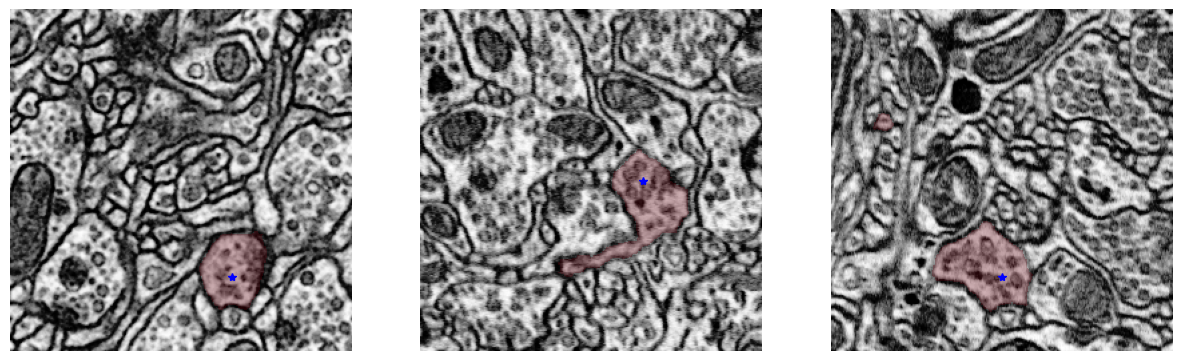

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, (frame, point) in zip(axs, frames):
    img = frame.image.load()
    lab = frame.label.load().astype(float)
    if frame.image.frame_axis == 2:
        # orient like in neuroglancer
        img = img.T[:, ::-1]
        point = (point[1], img.shape[0] - point[0])
        lab = lab.T[:, ::-1]
    label = lab[*point]
    lab[lab != label] = np.nan
    lab[lab == label] = 1
    
    plt.sca(ax)
    plt.imshow(img, cmap='grey')
    plt.imshow(lab, cmap='Reds', vmin=0, vmax=1, alpha=0.3)
    plt.plot(point[1], point[0], marker='*', color='b')
    plt.axis('off')
plt.show()

In [54]:
sam2_ft_checkpoint = "tuned_sam_model_20240930T224511.pt"
model_cfg_ft = "sam2_hiera_s.yaml"

model = build_sam2(model_cfg_ft, sam2_ft_checkpoint, device=device, apply_postprocessing=False)

mask_predictor = SAM2ImagePredictor(model)

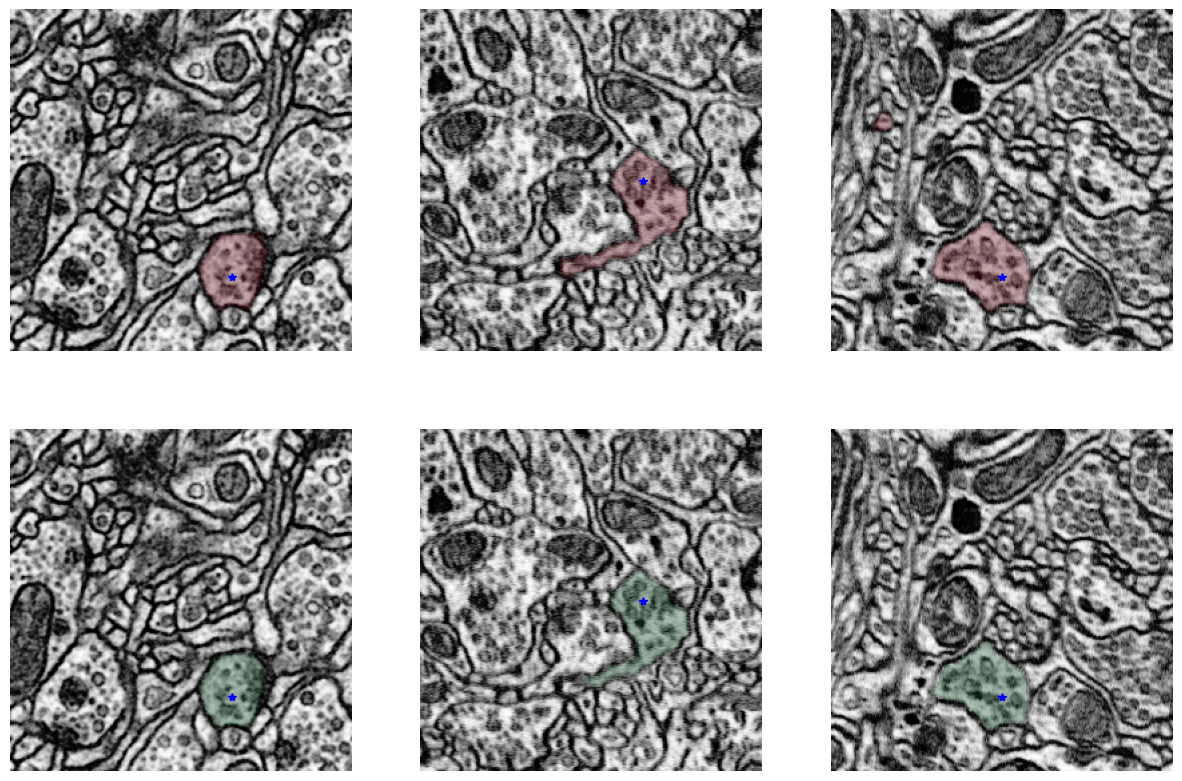

In [64]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for (ax0, ax1), (frame, point) in zip(axs.T, frames):
    img = frame.image.load()
    lab = frame.label.load().astype(float)
    if frame.image.frame_axis == 2:
        # orient like in neuroglancer
        img = img.T[:, ::-1]
        point = (point[1], img.shape[0] - point[0])
        lab = lab.T[:, ::-1]
    label = lab[*point]
    lab[lab != label] = np.nan
    lab[lab == label] = 1

    img3 = img[:, :, np.newaxis]
    img3 = np.concatenate([img3, img3, img3], axis=2)
    input_point = input_point = np.array([point[::-1]])
    input_label = np.array([1])
    mask_predictor.set_image(img3)
    pred_mask = mask_predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=False)[0][0]
    pred_mask[pred_mask == 0] = np.nan
    
    plt.sca(ax0)
    plt.imshow(img, cmap='grey')
    plt.imshow(lab, cmap='Reds', vmin=0, vmax=1, alpha=0.3)
    plt.plot(point[1], point[0], marker='*', color='b')
    plt.axis('off')

    plt.sca(ax1)
    plt.imshow(img, cmap='grey')
    plt.imshow(pred_mask, cmap='Greens', vmin=0, vmax=1, alpha=0.3)
    plt.plot(point[1], point[0], marker='*', color='b')
    plt.axis('off')
plt.show()